### Site for data:
 https://www.wsj.com/market-data/quotes/etf/SPY/historical-prices
 
 https://www.cboe.com/tradable_products/vix/vix_historical_data/

### Importing Modules and Libraries

In [39]:
# Importing Libraries

import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 

from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error, make_scorer, accuracy_score

from urllib.request import urlretrieve
import requests

import os
import warnings
warnings.filterwarnings('ignore')

### Loading and Analyzing Dataset

In [2]:
# dlurl = 'https://cdn.cboe.com/api/global/us_indices/daily_prices/VIX_History.csv'
# req = requests.get(dlurl)
# fname = req.url[dlurl.rfind('/') + 1 :]
# fname

In [3]:
# Importing dataset

filename = r'../Portfolio/HistoricalPrices.csv'
vix_csv = r'https://cdn.cboe.com/api/global/us_indices/daily_prices/VIX_History.csv'
data = pd.read_csv(filename)
vix_data_full= pd.read_csv(vix_csv)

In [4]:
vix_data_full.DATE = pd.to_datetime(vix_data_full.DATE)

In [5]:
# Data analytics
data.info() 

# convert Date to date datatype

data['Date'] = pd.to_datetime(data['Date'])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2522 entries, 0 to 2521
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Date     2522 non-null   object 
 1    Open    2522 non-null   float64
 2    High    2522 non-null   float64
 3    Low     2522 non-null   float64
 4    Close   2522 non-null   float64
 5    Volume  2522 non-null   int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 118.3+ KB


In [6]:
# readjust VIX dataset to match date range
first_date = data.iloc[len(data.Date) - 1 ,:].Date
last_date = data.iloc[0, :].Date

In [7]:
vix_data_full['COUNTER'] = [i for i in range(len(vix_data_full))]

In [8]:
# change index for vix and stock charts
vix_data_full = vix_data_full.set_index('DATE')
data = data.set_index('Date')

In [9]:
vix_first_date_index = int(vix_data_full[vix_data_full.index == first_date]['COUNTER'])
vix_last_date_index = int(vix_data_full[vix_data_full.index == last_date]['COUNTER'])

In [10]:
vix_data = vix_data_full.iloc[vix_first_date_index : vix_last_date_index + 1, :]
vix_data = vix_data.iloc[::-1,:]

In [11]:
# fixing column names 
vix_data.rename(inplace = True, columns = 
                {
                    'OPEN' : 'VIX_OPEN',
                    'HIGH' : 'VIX_HIGH',
                    'LOW' : 'VIX_LOW',
                    'CLOSE' : 'VIX_CLOSE'
                })

vix_data.index.names = ['Date']
vix_data.drop(columns = 'COUNTER', inplace = True)

In [12]:
full_data = vix_data.join(data)
full_data.reset_index(inplace = True)
full_data.columns = full_data.columns.str.strip()

In [13]:
# dropping null values
drop_index = list(full_data[full_data['Open'].isnull()].index)
full_data.drop(index = drop_index, inplace = True)
full_data.set_index('Date', inplace = True)

In [14]:
# reversing the data
full_data = full_data.iloc[::-1]

In [15]:
full_data

,VIX_OPEN,VIX_HIGH,VIX_LOW,VIX_CLOSE,Open,High,Low,Close,Volume
Date,,,,,,,,,
2013-11-15,12.12,12.45,11.99,12.19,179.5600,180.120,179.3300,180.05,102818203.0
2013-11-18,12.41,13.22,12.41,13.10,180.3500,180.500,179.0200,179.42,104796000.0
2013-11-19,13.03,13.68,12.88,13.39,179.3300,179.870,178.7200,179.03,93891422.0
2013-11-20,13.56,13.94,12.97,13.40,179.3900,179.930,177.9800,178.47,124908602.0
2013-11-21,13.09,13.09,12.44,12.66,178.9700,180.050,178.8600,179.91,92841273.0
...,...,...,...,...,...,...,...,...,...
2023-11-16,14.12,14.42,13.68,14.32,449.2200,450.560,448.1200,450.23,66665797.0
2023-11-17,14.18,14.19,13.67,13.80,450.2400,451.420,449.2900,450.79,83193906.0
2023-11-20,14.26,14.31,13.39,13.41,450.5300,455.125,450.5200,454.26,70055633.0


(20270010.0, 507244281.0)

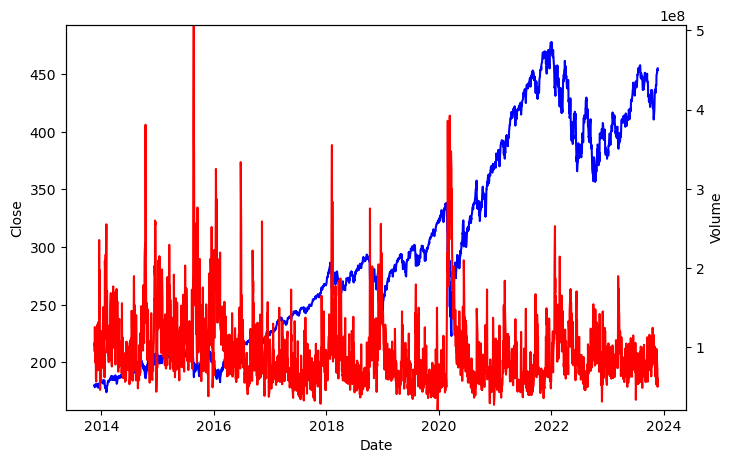

In [16]:
# Visualize the dataset

fig, axes = plt.subplots(sharey = True, figsize = (8,5))
axes2 = axes.twinx()
sns.lineplot(data = full_data, x = 'Date', y = 'Close', color = 'blue', ax = axes)
sns.lineplot(data = full_data, x = 'Date', y = 'Volume', color = 'red', ax = axes2)
axes2.set_ylim(full_data['Volume'].min(),full_data['Volume'].max())

In [17]:
roll_volume = full_data['Volume'].rolling(5).mean()
roll_volume

Date
2013-11-15            NaN
2013-11-18            NaN
2013-11-19            NaN
2013-11-20            NaN
2013-11-21    103851100.0
                 ...     
2023-11-16     76592885.8
2023-11-17     75320057.6
2023-11-20     78883970.2
2023-11-21     69297509.4
2023-11-22     65721308.6
Name: Volume, Length: 2522, dtype: float64

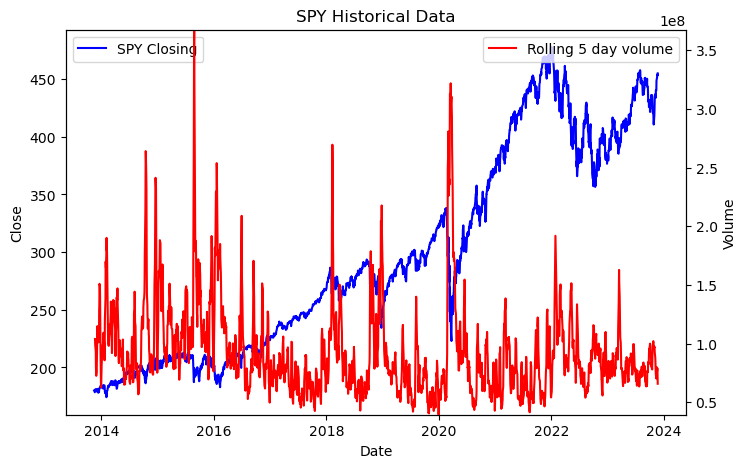

In [18]:
# Visualize the dataset

fig, axes = plt.subplots(sharey = True, figsize = (8,5))
axes2 = axes.twinx()
sns.lineplot(data = full_data, x = 'Date', y = 'Close', color = 'blue', label = 'SPY Closing', ax = axes)
sns.lineplot(data = full_data, x = 'Date', y = roll_volume, color = 'red', label = 'Rolling 5 day volume', ax = axes2)
axes2.set_ylim(roll_volume.min(),roll_volume.max())
axes.set_title('SPY Historical Data');

In [19]:
full_data['Green_or_red'] = ['Green' if full_data['Open'][i] < full_data['Close'][i] else 'Red' for i in range(len(full_data['Open']))]
# Determine whether the stock was green or red for the day based on the closing and opening price

In [20]:
full_data['Green_or_red'] = full_data['Green_or_red'].map(lambda x: 1 if x == 'Green' else 0)

### Preparing data for training and testing

In [21]:
# Train and test split

split = int(len(full_data) * 0.80)
train = full_data[:split]
test = full_data[split:]

X_train, y_train = train.drop(columns = ['Close','Green_or_red']), train['Close']
X_test, y_test = test.drop(columns = ['Close','Green_or_red']), test['Close']

### XGBoost Regressor

In [22]:
# xgboost regressor 
params = {
    'n_estimators' : [50,100,500,100],
    'max_depth' : [5,7],
    'eta' : [0.001,0.01,0.05,0.1]
    }

metrics = 'neg_mean_absolute_error'
# metrics = {
#     'neg_mean_absolute_error' : make_scorer(mean_absolute_error),
#     'neg_mean_squared_error' : make_scorer(mean_squared_error)
# }
xgb_model = xgb.XGBRegressor()
clf = GridSearchCV(estimator = xgb_model, param_grid = params, scoring = metrics, verbose = 2)
clf.fit(X_train, y_train)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
[CV] END ............eta=0.001, max_depth=5, n_estimators=50; total time=   0.1s
[CV] END ............eta=0.001, max_depth=5, n_estimators=50; total time=   0.0s
[CV] END ............eta=0.001, max_depth=5, n_estimators=50; total time=   0.0s
[CV] END ............eta=0.001, max_depth=5, n_estimators=50; total time=   0.0s
[CV] END ............eta=0.001, max_depth=5, n_estimators=50; total time=   0.0s
[CV] END ...........eta=0.001, max_depth=5, n_estimators=100; total time=   0.1s
[CV] END ...........eta=0.001, max_depth=5, n_estimators=100; total time=   0.1s
[CV] END ...........eta=0.001, max_depth=5, n_estimators=100; total time=   0.1s
[CV] END ...........eta=0.001, max_depth=5, n_estimators=100; total time=   0.1s
[CV] END ...........eta=0.001, max_depth=5, n_estimators=100; total time=   0.1s
[CV] END ...........eta=0.001, max_depth=5, n_estimators=500; total time=   0.3s
[CV] END ...........eta=0.001, max_depth=5, n_e

GridSearchCV(estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_bi...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             param_grid={'eta': [0.001, 0.01, 0.05, 0.1], 'max_depth': [5, 7],
                         'n_estimators': [50, 100, 500, 100]},
             scoring='neg_mean_absolute_error', verbose=2)

In [23]:
xgb_clf = clf.best_estimator_
y_pred = xgb_clf.predict(X_test)

In [24]:
# mae, mse, and rmse

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f'MAE: {mae}\nMSE: {mse}\nRMSE: {rmse}')

MAE: 2.550129699102723
MSE: 11.523596684496509
RMSE: 3.394642350012223


Text(0.5, 1.0, 'Test and predictions')

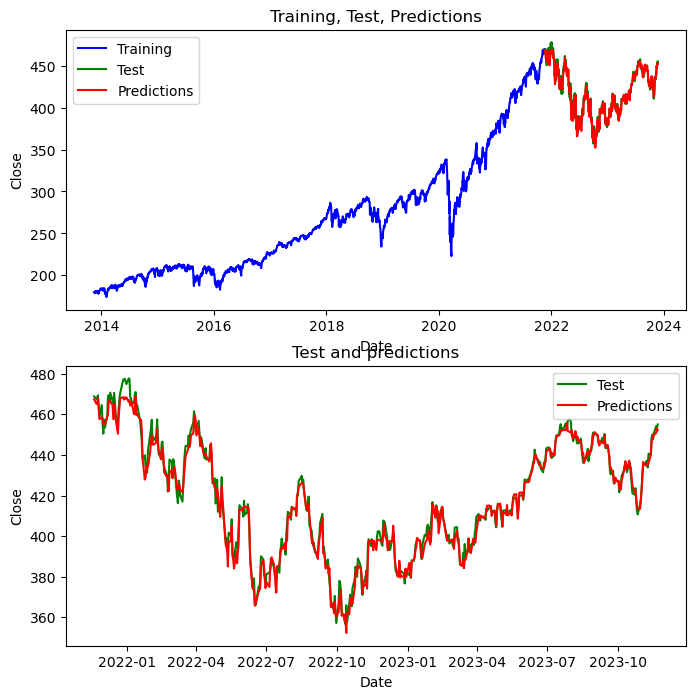

In [25]:
# visual visual representation 

fig, ax = plt.subplots(2, 1, figsize = (8,8))
sns.lineplot(data = train, x = train.index, y = 'Close', color = 'blue', label = 'Training', ax = ax[0])
sns.lineplot(data = test, x = test.index, y = 'Close', color = 'green', label = 'Test', ax = ax[0])
sns.lineplot(x = test.index, y = y_pred, color = 'red', label = 'Predictions', ax = ax[0])
ax[0].set_title('Training, Test, Predictions')
sns.lineplot(data = test, x = test.index, y = 'Close', color = 'green', label = 'Test', ax = ax[1])
sns.lineplot(x = test.index, y = y_pred, color = 'red', label = 'Predictions', ax = ax[1])
ax[1].set_title('Test and predictions')

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

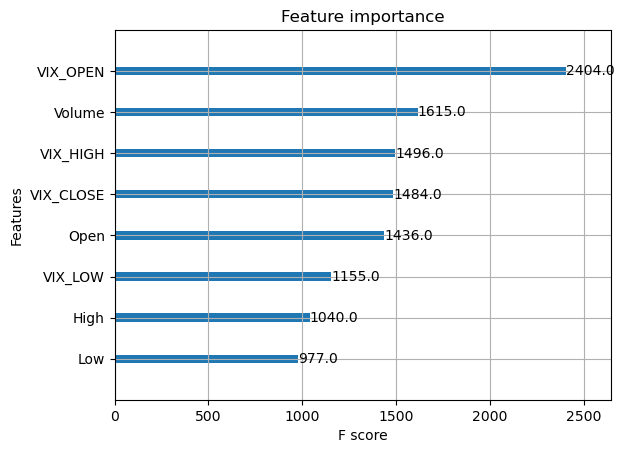

In [26]:
xgb.plot_importance(xgb_clf)

### Feature Selection 

In [27]:
# Feature Selection -> USING ONLY VIX OPEN and Open
X_train_1 = X_train.drop(columns = ['VIX_HIGH','VIX_LOW','VIX_CLOSE','High','Low','Volume'])
X_test_1 = X_test.drop(columns = ['VIX_HIGH','VIX_LOW','VIX_CLOSE','High','Low','Volume'])

In [28]:
X_test_2 = full_data[split:].drop(columns = ['VIX_HIGH','VIX_LOW','VIX_CLOSE','High','Low','Volume','Close','Green_or_red'])

In [29]:
model1 = xgb.XGBRegressor(eta = 0.1, max_depth = 5, n_estimators = 500)
model1.fit(X_train_1, y_train)
y_pred_1 = model1.predict(X_test_1)

In [30]:
y_pred_2 = model1.predict(X_test_2)

<Axes: xlabel='Date', ylabel='Close'>

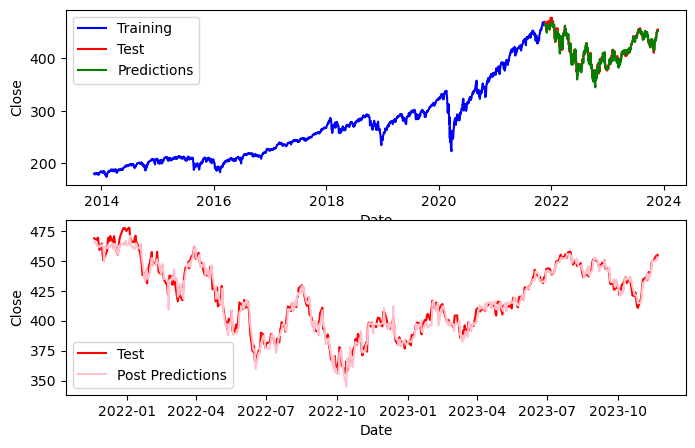

In [31]:
fig, ax = plt.subplots(2,1,figsize = (8,5))
sns.lineplot(x = X_train.index, y = y_train, c = 'blue', label = 'Training', ax = ax[0])
sns.lineplot(x = X_test_1.index, y = y_test, c = 'red', label = 'Test', ax = ax[0])
sns.lineplot(x = X_test_1.index, y = y_pred_1, c = 'green', label = 'Predictions', ax = ax[0])

sns.lineplot(x = full_data.index[split:], y = full_data['Close'][split:], c = 'red', label = 'Test', ax = ax[1])
sns.lineplot(x = X_test_2.index, y = y_pred_2, c = 'pink', label = 'Post Predictions', ax = ax[1])

**Notes:** We can try other models to see if we can only use volume and open features to predict future prices. We can try rolling, moving averages of values to predict the immediate future...

- Let's try Prophet, LSTM, DeepAR, N-BEATS, Temporal Fusion Transformer (Google)

- Try including VIX within the feature set?

- Try lagging the data? (x-1) to use the prior day highs and lows


### Stock Predictor using XGBoost

In [32]:
# full_data # create a function to predict

def stockPredictor(dataset: pd.DataFrame, VIX_Open: float, Open: float):
    
    X_train = dataset.drop(columns = ['VIX_HIGH','VIX_LOW','VIX_CLOSE','High','Low','Volume','Close','Green_or_red'])
    y_train = dataset['Close']

    model = xgb.XGBRegressor(eta = 0.1, max_depth = 5, n_estimators = 500) # will need to update using more data
    model.fit(X_train,y_train)
    y_pred = model.predict(np.array([[VIX_Open,Open]]))
    
    return y_pred[0]

In [33]:
stockPredictor(full_data, VIX_Open = 13.03, Open = 455.07)

454.80066

### XGBoost Classifier

In [52]:
def stockPredictorClassifier(dataset: pd.DataFrame):
    
    split = int(0.8 * len(dataset))
    X_train = dataset.drop(columns = ['VIX_HIGH','VIX_LOW','VIX_CLOSE','High','Low','Volume','Green_or_red','Close'])[:split]
    X_test = dataset.drop(columns = ['VIX_HIGH','VIX_LOW','VIX_CLOSE','High','Low','Volume','Green_or_red','Close','Green_or_red','Close'])[split:]
    y_train = dataset['Green_or_red'][:split]
    y_test = dataset['Green_or_red'][split:]
    
    params = {
    'n_estimators' : [50,100,500,100],
    'max_depth' : [5,7],
    'eta' : [0.001,0.01,0.05,0.1]
    }

    model = xgb.XGBClassifier()
    clf = GridSearchCV(estimator = model, param_grid = params, verbose = 2)
    clf.fit(X_train, y_train)
    model_best = clf.best_estimator_
    model_best.fit(X_train, y_train)
    y_pred = model_best.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    
    return acc

In [53]:
stockPredictorClassifier(full_data)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
[CV] END ............eta=0.001, max_depth=5, n_estimators=50; total time=   0.0s
[CV] END ............eta=0.001, max_depth=5, n_estimators=50; total time=   0.0s
[CV] END ............eta=0.001, max_depth=5, n_estimators=50; total time=   0.0s
[CV] END ............eta=0.001, max_depth=5, n_estimators=50; total time=   0.0s
[CV] END ............eta=0.001, max_depth=5, n_estimators=50; total time=   0.0s
[CV] END ...........eta=0.001, max_depth=5, n_estimators=100; total time=   0.1s
[CV] END ...........eta=0.001, max_depth=5, n_estimators=100; total time=   0.1s
[CV] END ...........eta=0.001, max_depth=5, n_estimators=100; total time=   0.0s
[CV] END ...........eta=0.001, max_depth=5, n_estimators=100; total time=   0.0s
[CV] END ...........eta=0.001, max_depth=5, n_estimators=100; total time=   0.0s
[CV] END ...........eta=0.001, max_depth=5, n_estimators=500; total time=   0.2s
[CV] END ...........eta=0.001, max_depth=5, n_e

0.5425742574257426

### Prophet

In [34]:
### train | test
### X_train,y_train | X_test, y_test

